In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Rescaling, Resizing
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, FalseNegatives, FalsePositives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import L2, L1
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve
import seaborn as sns

# **DATA PREPARATION**

## **DATA LOADING**

In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))

  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))
  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))

  return train_dataset, val_dataset, test_dataset


TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# dataset = tf.data.Dataset.range(10)

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()))
print(val_dataset.take(1))
print(test_dataset.take(1))

# for data in dataset[0].take(1):
#     print(data)

## **DATA VISUALISATION**

In [ ]:
for i , (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [ ]:
dataset_info.features['label'].int2str(1)

## **DATA PREPROCESSING**

### **DATA AUGMENTATION**

In [ ]:
def visualize(original, augmented):
  plt.subplot(1, 2, 1)
  plt.imshow(original)

  plt.subplot(1, 2, 2)
  plt.imshow(augmented)

In [ ]:
original_image, label = next(iter(train_dataset))
# label = label[0]
# original_image.shape

In [8]:
# augmented_image = tf.image.flip_left_right(original_image)
# augmented_image = tf.image.rot90(original_image)
# augmented_image = tf.image.adjust_brightness(original_image, delta=0.2)
augmented_image = tf.image.random_saturation(original_image, lower=0, upper=1)

augmented_image.shape

TensorShape([151, 115, 3])

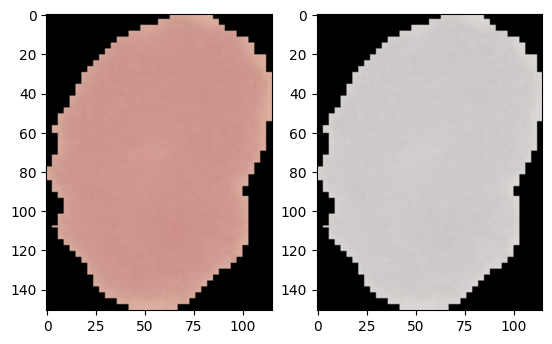

In [9]:
visualize(original_image, augmented_image)

In [10]:
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [11]:
### tf.image augment
def augment(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.rot90(image)
  # image = tf.image.adjust_saturation(image, saturation_factor=0.3)
  image = tf.image.flip_left_right(image)

  return image, label

In [12]:
### tf.keras.layer resizing and rescaling

resize_rescale_layers = tf.keras.Sequential([
  Resizing(IM_SIZE, IM_SIZE),
  Rescaling(1./255)
])

In [13]:
### tf.keras.layer augment
augment_layers = tf.keras.Sequential([
  RandomRotation(factor=(0.25, 0.2501),),
  RandomFlip(mode='horizontal'),
])

def augment_layer(image, label):
  return augment_layers(resize_rescale_layers(image), training=True), label

## **DATA LOADING**

In [14]:
BATCH_SIZE = 32
test_dataset = test_dataset.map(resize_rescale)

In [15]:
train_dataset = (
  train_dataset
  .shuffle(buffer_size=8, reshuffle_each_iteration=True)
  .map(augment_layer)
  .batch(BATCH_SIZE)
  .prefetch(tf.data.AUTOTUNE)
)

In [16]:
val_dataset = (
  val_dataset
  .shuffle(buffer_size=8, reshuffle_each_iteration=True)
  .map(resize_rescale)
  .batch(BATCH_SIZE)
  .prefetch(tf.data.AUTOTUNE)
)

# **MODEL CREATION**

## **SEQUENTIAL MODEL**

In [17]:
dropout_rate = 0.3
regularization_rate = 0.01

In [18]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters=6, kernel_size=5, strides=1, padding="valid",
           activation='relu', kernel_regularizer = L2(regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(rate = dropout_rate),

    Conv2D(filters=16, kernel_size=5, strides=1, padding="valid",
           activation='relu', kernel_regularizer = L2(regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation='relu', kernel_regularizer = L2(regularization_rate)),
    BatchNormalization(),
    Dropout(rate = dropout_rate),

    Dense(10, activation='relu', kernel_regularizer = L2(regularization_rate)),
    BatchNormalization(),

    Dense(1, activation='sigmoid'),
])

lenet_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 220, 220, 6)         │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 220, 220, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 110, 110, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 106, 106, 16)        │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 106, 106, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 53, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 44944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       4,494,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,498,921 (17.16 MB)

 Trainable params: 4,498,657 (17.16 MB)

 Non-trainable params: 264 (1.03 KB)

In [ ]:
feature_extractor_model_seq = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters=6, kernel_size=5, strides=1, padding="valid", activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=5, strides=1, padding="valid", activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
])

feature_extractor_model_seq.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 220, 220, 6)         │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 220, 220, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 110, 110, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 106, 106, 16)        │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 106, 106, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 53, 53, 16)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,960 (11.56 KB)

 Trainable params: 2,916 (11.39 KB)

 Non-trainable params: 44 (176.00 B)

## **FUNCTIONAL API**

In [ ]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name='Input_Image')

x = Conv2D(filters=6, kernel_size=5, strides=1, padding="valid", activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=16, kernel_size=5, strides=1, padding="valid", activation='relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)

feature_extractor_model = Model(func_input, output, name="Feature_Extractor")
feature_extractor_model.summary()

Model: "Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_Image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 220, 220, 6)         │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 220, 220, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 110, 110, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 106, 106, 16)        │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 106, 106, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 53, 53, 16)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,960 (11.56 KB)

 Trainable params: 2,916 (11.39 KB)

 Non-trainable params: 44 (176.00 B)

In [ ]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name='Input_Image')

x = feature_extractor_model(func_input)
x = Flatten()(x)

x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation='sigmoid')(x)

lenet_model_func = Model(func_input, func_output, name="LenetModel")

lenet_model_func.summary()

Model: "LenetModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_Image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Feature_Extractor (Functional)       │ (None, 53, 53, 16)          │           2,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 44944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │       4,494,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,498,921 (17.16 MB)

 Trainable params: 4,498,657 (17.16 MB)

 Non-trainable params: 264 (1.03 KB)

## **MODEL SUBCLASSING**

In [ ]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_1 = BatchNormalization()
    self.maxpool_1 = MaxPool2D(pool_size=pool_size, strides=2*strides)

    self.conv_2 = Conv2D(filters=filters*2, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_2 = BatchNormalization()
    self.maxpool_2 = MaxPool2D(pool_size=pool_size, strides=2*strides)

  def call(self, input_tensor):
    x = self.conv_1(input_tensor)
    x = self.batch_1(x)
    x = self.maxpool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.maxpool_2(x)

    return x

feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)


In [ ]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation='relu')
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation='relu')
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation='sigmoid')

  def call(self, input_tensor):
    x = self.feature_extractor(input_tensor)
    x = self.flatten(x)

    x = self.dense_1(x)
    x = self.batch_1(x)

    x = self.dense_2(x)
    x = self.batch_2(x)

    x = self.dense_3(x)

    return x

lenet_model_subclassed = LenetModel()
lenet_model_subclassed(tf.zeros([1, 224, 224, 3]))
lenet_model_subclassed.summary()

Model: "lenet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ feature_extractor_1                  │ ?                           │           1,488 │
│ (FeatureExtractor)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (1, 46656)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (1, 100)                    │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (1, 100)                    │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (1, 10)                     │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (1, 10)                     │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (1, 1)                      │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,649 (17.81 MB)

 Trainable params: 4,668,381 (17.81 MB)

 Non-trainable params: 268 (1.05 KB)

In [ ]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name='Input_Image')

x = feature_sub_classed(func_input)
x = Flatten()(x)

x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation='sigmoid')(x)

lenet_model_func = Model(func_input, func_output, name="LenetModel")

lenet_model_func.summary()

Model: "LenetModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_Image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_extractor (FeatureExtractor) │ (None, 54, 54, 16)          │           1,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,649 (17.81 MB)

 Trainable params: 4,668,381 (17.81 MB)

 Non-trainable params: 268 (1.05 KB)

## **CUSTOM LAYERS**




In [ ]:
class NeuralearnDense(Layer):
  def __init__(self, output_units, activation):
    super(NeuralearnDense, self).__init__()
    self.output_units = output_units
    self.activation = activation

  def build(self, input_features_shape):
    self.w = self.add_weight(shape=(input_features_shape[-1], self.output_units), initializer="random_normal", trainable=True)
    self.b = self.add_weight(shape=(self.output_units,), initializer="random_normal", trainable=True)

  def call(self, input_features):
    pre_output = tf.matmul(input_features, self.w) + self.b
    if self.activation == "relu":
      return tf.nn.relu(pre_output)
    elif self.activation == "sigmoid":
      return tf.nn.sigmoid(pre_output)
    else:
      return pre_output

In [ ]:
lenet_custom_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters=6, kernel_size=5, strides=1, padding="valid", activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=5, strides=1, padding="valid", activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    NeuralearnDense(100, activation='relu'),  # <------
    BatchNormalization(),
    NeuralearnDense(10, activation='relu'),   # <------
    BatchNormalization(),
    NeuralearnDense(1, activation='sigmoid'),  # <------
])

lenet_custom_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 220, 220, 6)         │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 220, 220, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 110, 110, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 106, 106, 16)        │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 106, 106, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 53, 53, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 44944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ neuralearn_dense (NeuralearnDense)   │ (None, 100)                 │       4,494,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ neuralearn_dense_1 (NeuralearnDense) │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ neuralearn_dense_2 (NeuralearnDense) │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,498,921 (17.16 MB)

 Trainable params: 4,498,657 (17.16 MB)

 Non-trainable params: 264 (1.03 KB)

# **CALLBACKS**

In [19]:
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print(f"\nFor Epoch Number {epoch} the model has a loss of {logs['loss']}")

  def on_batch_end(self, batch, logs):
    print(f"\nFor Batch Number {batch+1} the model has a loss of {logs}")

## **CSVLOGGER**

In [20]:
csv_callback = tf.keras.callbacks.CSVLogger('logs.csv', separator=',', append=True)

## **EARLYSTOPPING**

In [21]:
es_callback = EarlyStopping(monitor='val_loss', patience=2, verbose=1,
                            mode='auto', baseline=None, restore_best_weights=False)

## **LEARNING RATE SCHEDULER**

In [22]:
def scheduler(epoch, lr):
  if epoch < 3:
    return float(lr)  # Ensure lr is a float
  else:
    return float(lr * tf.math.exp(-0.1).numpy())  # Convert Tensor to float

scheduler_callback = LearningRateScheduler(scheduler, verbose=1)

## **MODEL CHECKPOINTING**

In [23]:
filepath = 'checkpoint.h5'

checkpoint_callback = ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq=3,
)

## **REDUCE LEARNING RATE ON PLATEAU**

In [24]:
plateau_callback = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=2, verbose=1,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0,
)

# **MODEL TRAINING**

In [25]:
metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
           BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]


In [26]:
# lenet_model.compile(
#     optimizer=Adam(learning_rate=0.01),
#     loss= BinaryCrossentropy(),
#     metrics=['accuracy']
#   )

lenet_model.compile(
    optimizer = Adam(learning_rate=0.01),
    loss = BinaryCrossentropy(),
    metrics = metrics
  )

In [27]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1, callbacks=[csv_callback, scheduler_callback, checkpoint_callback])

# history = lenet_custom_model.fit(train_dataset, validation_data=val_dataset, epochs=1, verbose=1, callbacks=[LossCallback(), csv_callback, es_callback, plateau_callback])



Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/10
  3/689 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.4531 - auc: 0.4696 - fn: 15.3333 - fp: 18.3333 - loss: 5.5328 - precision: 0.4707 - recall: 0.5209 - tn: 12.0000 - tp: 18.3333

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:202: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 209s 287ms/step - accuracy: 0.6194 - auc: 0.6638 - fn: 2107.5129 - fp: 2050.7319 - loss: 6.7891 - precision: 0.6221 - recall: 0.6234 - tn: 3468.0044 - tp: 3429.6985 - val_accuracy: 0.4933 - val_auc: 0.6425 - val_fn: 1396.0000 - val_fp: 0.0000e+00 - val_loss: 6.8621 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 1359.0000 - val_tp: 0.0000e+00 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 250s 279ms/step - accuracy: 0.6417 - auc: 0.6870 - fn: 2009.5479 - fp: 1986.8260 - loss: 3.2378 - precision: 0.6462 - recall: 0.6375 - tn: 3532.0464 - tp: 3527.5276 - val_accuracy: 0.4951 - val_auc: 0.5995 - val_fn: 1390.0000 - val_fp: 1.0000 - val_loss: 3.8653 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 1364.0000 - val_tp: 0.0000e+00 - learning_rate: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/1

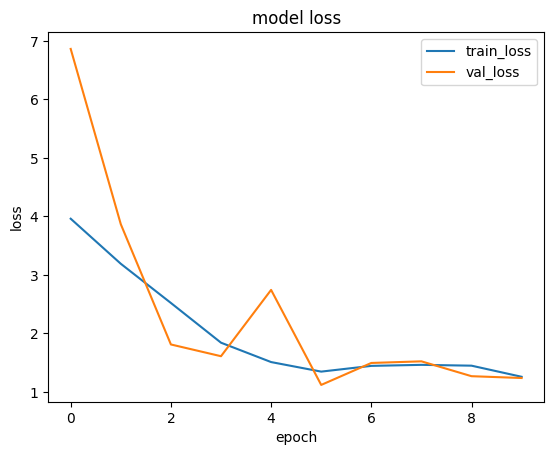

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

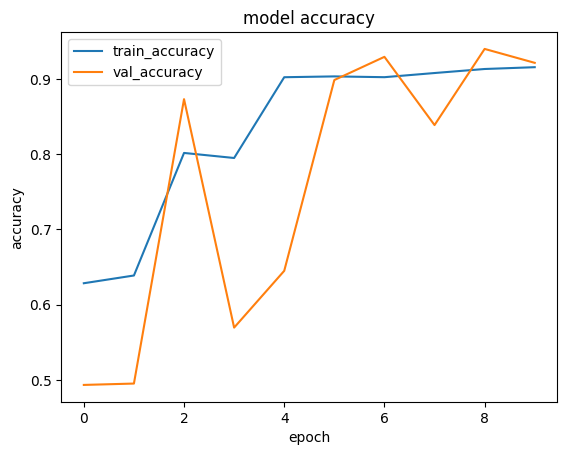

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# **MODEL EVALUATION AND TESTING**

In [30]:
test_dataset = test_dataset.batch(1)

In [31]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [32]:
lenet_model.evaluate(test_dataset)

2757/2757 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.9173 - auc: 0.9402 - fn: 86.9764 - fp: 25.9474 - loss: 1.2539 - precision: 0.9571 - recall: 0.8727 - tn: 667.0319 - tp: 599.5439


[1.2509214878082275,
 1183.0,
 54.0,
 1344.0,
 176.0,
 0.9165759682655334,
 0.9563459753990173,
 0.8704929947853088,
 0.940265953540802]

# **VISUALIZING CONFUSION MATRIX**

In [33]:
labels = []
inp = []

for x, y in test_dataset.as_numpy_iterator():
  labels.append(y)
  inp.append(x)

In [34]:
print(np.array(labels).shape)
print(np.array(inp).shape)

(2757, 1)
(2757, 1, 224, 224, 3)


In [35]:
print(labels)
labels = np.array([i[0] for i in labels])
print(labels)

[array([1]), array([1]), array([1]), array([1]), array([1]), array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([1]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([1]), array([0]), array([1]), array([0]), array([0]), array([0]), array([1]), array([0]), array([0]), array([0]), array([0]), array([1]), array([0]), array([0]), array([0]), array([1]), array([1]), array([1]), array([0]), array([1]), array([1]), array([1]), array([0]), array([1]), array([1]), array([0]), array([1]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([0]), array([0]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0]), array([0]), array([0]), array([0]), arr

In [36]:
predicted = lenet_model.predict(np.array(inp)[:, 0, ...])

87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step


In [37]:
print(predicted[:, 0].shape)
print(predicted[:, 0])

(2757,)
[0.519928   0.52625626 0.5263615  ... 0.5252922  0.02581776 0.02632026]


[[1343   52]
 [ 176 1186]]


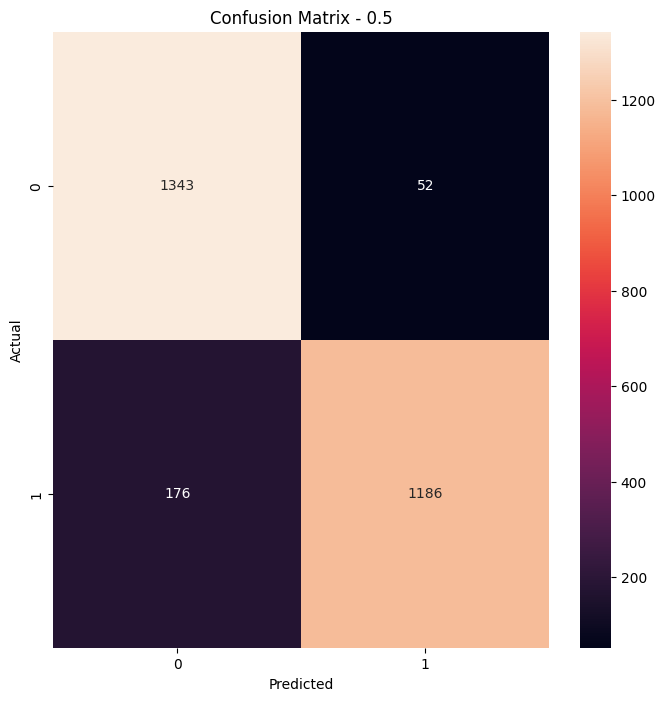

In [38]:
threshold = 0.5

cm = confusion_matrix(labels, predicted > threshold)
print(cm)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix - {}'.format(threshold))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **ROC Plots**

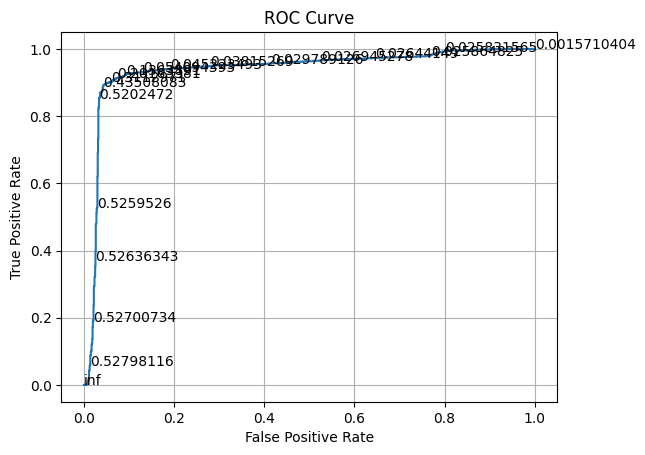

In [39]:
fp, tp, thresholds = roc_curve(labels, predicted)
# print(len(fp), len(tp), len(thresholds))

plt.plot(fp, tp)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.grid(True)

skip = 20
for i in range(0, len(thresholds), skip):
  plt.text(fp[i], tp[i], thresholds[i])

plt.show()

In [40]:
def parasite_or_not(x):
  print(x)
  if(x<0.5):
    return str('P')
  else:
    return str('U')

In [41]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
0.52592313


'U'

1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
0.5260324
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
0.52511716
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0.05504415
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
0.026286222
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
0.52680093
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0.5273994
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0.02669226
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
0.5271187
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
0.5270781
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0.027162451
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
0.52706945
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0.52614045
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0.51318747
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0.02936888
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
0.52718425
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0.52606744


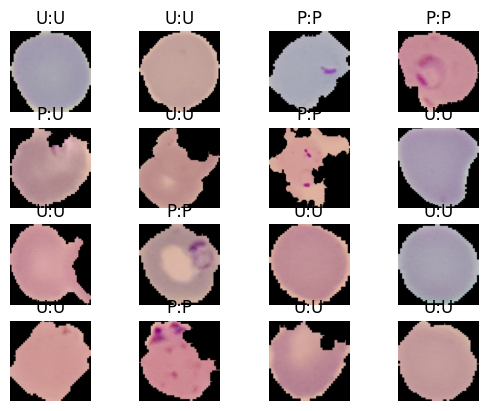

In [43]:
for i, (image, label) in enumerate(test_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image[0])

  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(lenet_model.predict(image)[0][0])))
  plt.axis('off')

# **SAVE MODEL**

In [44]:
lenet_model.save('lenet_model_malaria.h5')

In [45]:
!ls

drive  lenet_model_malaria.h5  logs.csv  sample_data


In [46]:
!cp -r ./lenet_model_malaria.h5 ./drive/MyDrive/AI/

trained model

https://drive.google.com/file/d/1-Z_wvqBMYZvBmUv0STibm-t39iBAhVsB/view?usp=drive_link

download and load 

In [ ]:
# model = tf.keras.models.load_model('lenet_model_malaria.h5')